# Example 3 – Nonlinear pipe network

This example corresponds to a **nonlinear hydraulic network**, extracted from:

* Brebbia, C. A., & Ferrante, A. J. (2013). *Computational Hydraulics*. Butterworth-Heinemann.
* Example figure 4.27.

Unlike the previous cases, the relationship between flow rate and head difference is **nonlinear**, which requires an **iterative solution method** (Newton–Raphson).

---

## 1. Governing nonlinear relationship

The starting point is the empirical relationship between **velocity** and **head loss**:

$$
V = 0.3545  c  D^{0.63} \frac{h^{0.54}}{L^{0.54}}
$$

Expressing the equation in terms of **flow rate** $Q$ and **head difference** $\Delta H$:

$$
Q = \left(0.2784 \frac{c D^{2.63}}{L^{0.54}} \right) \Delta H^{0.54}
$$

This can be written compactly as:

$$
Q = k , \Delta H^{0.54}
$$

where the nonlinear hydraulic coefficient is:

$$
k = 0.2784 \frac{c D^{2.63}}{L^{0.54}}
$$

---

## 2. Reformulation for numerical solution

To fit the standard **diffusive system matrix form**, the nonlinear equation is reorganized as:

$$
Q^i = \frac{k^i}{\left(\Delta H^i\right)^{0.46}}  \Delta H^i
$$

Defining an **effective nonlinear conductivity**:

$$
\overline{k}^i = \frac{k^i}{\left(\Delta H^i\right)^{0.46}}
$$

Thus, the element matrix becomes:

$$
\begin{bmatrix}
Q_k^i \\
Q_j^i
\end{bmatrix}
= \overline{k}^i
\begin{bmatrix}
1 & -1 \\
-1 & 1
\end{bmatrix}
\begin{bmatrix}
H_k^i \\
H_j^i
\end{bmatrix}
$$

This formulation allows the nonlinear system to be solved iteratively by updating $\overline{k}^i$ at each iteration.

---

## 3. Network definition

### Step 3.1 – Create the network and connectivity

In [42]:
import numpy as np
import netsystems as ns

In [43]:
net = ns.Network()

connectivity = np.array([
    [0, 1], [0, 2], [1, 2], [1, 3], [2, 3],
    [2, 4], [3, 4], [3, 5], [4, 5], [4, 6],
    [6, 7], [5, 7]
])

net.set_connectivity(connectivity)

### Step 3.2 – Define node coordinates and compute pipe lengths

The element lengths $L_i$ are computed automatically from node coordinates.

In [44]:
net.node_coordinates = np.array([
    [0, 0], [0, 500], [250, 0], [250, 500],
    [550, 0], [750, 500], [950, -100], [850, 200]
])

net.calculate_element_lengths()

## 4. Definition of the nonlinear fluid system

### Step 4.1 – Create the diffusive system

In [45]:
fluid = ns.System("fluid", system_type="diffusive")

fluid.x_name = "H"
fluid.b_name = "C"
fluid.element_variable_name = "Q"

### Step 4.2 – Boundary conditions

* **Known head** at node 6
* **Known nodal flows** at all other nodes

In [46]:
fluid.known_x_nodes = np.array([6])
fluid.known_x_values = np.array([0.0])

fluid.known_b_nodes = np.array([0, 1, 2, 3, 4, 5, 7])
fluid.known_b_values = np.array([
    -0.0311, 0.09, -0.0113, -0.011,
    -0.0101, 0.02, -0.015
])

## 5. Hydraulic properties and initial approximation

### Step 5.1 – Pipe diameters and Hazen–Williams coefficient

In [47]:
diameters = np.array([
    0.1524, 0.1524, 0.1524, 0.1270, 0.1016, 0.1270,
    0.1016, 0.1524, 0.1270, 0.1270, 0.1016, 0.1524
])

hazen_williams_coef = 110
fluid.element_diameter = diameters

### Step 5.2 – Initial (linearized) hydraulic coefficient

For the **initial guess**, the nonlinear exponent is ignored:

$$
k^i = 0.2784 \frac{c D^{2.63}}{L^{0.54}}
$$


In [48]:
fluid.element_conductance = (
    0.2784 * hazen_williams_coef * diameters[:] ** 2.63 /
    (net.element_lengths[:] ** 0.54)
)

This provides a **linear approximation** used only to start the Newton–Raphson iterations.

---

## 6. Nonlinear hydraulic property function

### Step 6.1 – Purpose of the function

At each iteration, the effective conductivity is updated as:

$$
\overline{k}^i = \frac{0.2784 c D^{2.63}}
{L^{0.54}  |\Delta H|^{0.46}}
$$

This reflects the nonlinear dependence of flow on head difference.

---

### Step 6.2 – Implementation

In [49]:

def calculate_nonlinear_fluid_conductance(network):
    system = network.systems["fluid"]

    # Current nodal heads (solution or estimate)
    heads = system.x
    # or 
    # heads = network.get("H")

    # Connectivity indices
    i = network.connectivity[:, 0].astype(int)
    j = network.connectivity[:, 1].astype(int)

    # Head difference ΔH
    delta_h = heads[i] - heads[j]
    abs_delta_h = np.abs(delta_h) + 1e-12

    # Pipe properties
    diameters = system.element_diameter
    C = 110

    # Nonlinear conductance
    k = (
        0.2784
        * C
        * diameters ** 2.63
        / network.element_lengths ** 0.54
        / abs_delta_h ** 0.46
    )

    return k

In [50]:
fluid.element_conductance_function = calculate_nonlinear_fluid_conductance

**Theory–code correspondence:**

* $\Delta H$ → `delta_h`
* $|\Delta H|^{0.46}$ → `abs_delta_h ** 0.46`
* $D^{2.63}$ → `diameters ** 2.63`
* $L^{0.54}$ → `network.element_lengths ** 0.54`

---

## 7. Solution using Newton–Raphson

### Step 7.1 – Add system and compute initial guess

In [51]:
net.add_system(fluid)

initial_guess = ns.get_initial_guess(net, "fluid")

### Step 7.2 – Solve nonlinear system

In [52]:
solution_nr = ns.solve_newton_raphson(
    network=net,
    system_name="fluid",
    initial_guess=initial_guess,
    tolerance=1e-6,
    max_iterations=40,
    verbose=True
)

[Newton] Iter 00 |R| = 9.643e-02
[Newton] Iter 01 |R| = 6.979e-02
[Newton] Iter 02 |R| = 2.601e-02
[Newton] Iter 03 |R| = 3.093e-03
[Newton] Iter 04 |R| = 7.579e-04
[Newton] Iter 05 |R| = 8.715e-04
[Newton] Iter 06 |R| = 2.253e-04
[Newton] Iter 07 |R| = 4.328e-05
[Newton] Iter 08 |R| = 1.618e-06
[Newton] Iter 09 |R| = 2.054e-09


At each iteration:

1. Heads are updated
2. $\Delta H$ is recomputed
3. $\overline{k}^i$ is updated
4. The global matrix is rebuilt

## 8. Accessing results

```python
fluid.x
net.get("Q")
net.get("C")
```

## 9. Results

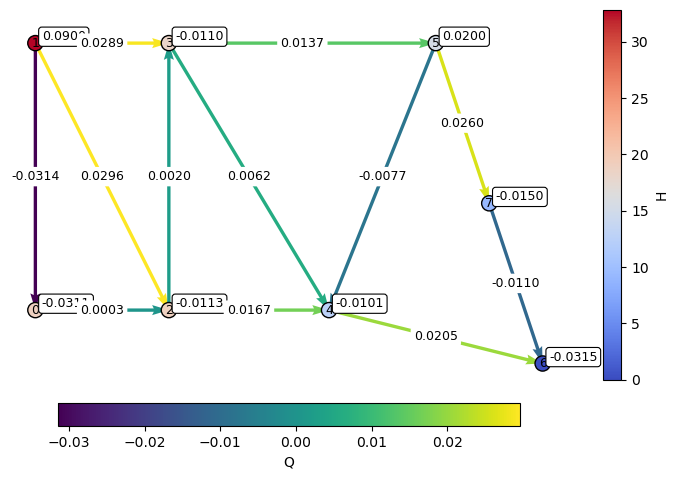

In [53]:
ns.plot_network_results(
    net,
    "Q",
    "C",
    node_values=net.get("H"),
    element_values=net.get("Q"),
    node_cmap="coolwarm",
    element_cmap="viridis",

    show_node_numbers=True,
    show_element_numbers=True,
    show_flow_arrows=True,

    show_element_values=True,
    element_value_format="{:.4f}",
    element_value_fontsize=9,
    element_value_color="black",
    element_value_bbox=True,

    show_node_demands=True,
    node_demand_format="{:.4f}",
    node_demand_fontsize=9,
    node_demand_color="black",
    node_demand_offset=(12, 12),
    node_demand_bbox=True,

    node_size=120,
    line_width=3.0,
    arrow_scale=1.0,
    arrow_width=0.006,
    figure_size=(9, 6),

    node_colorbar_label="H",
    element_colorbar_label="Q",
    title=None,
    axis_off=True,

    save_figure=False,
    figure_name="figure.png",
    dpi=300,
    pad_inches=0.05,
)